## Test steerable canonicalization
In this notebook, we test the whether the steerable image canonicalizers can generate a canonical orientation properly for sample images. We also visualize the original and canonicalized images to see if the canonicalization is successful.

In [1]:
import torch
from torchvision import datasets, transforms
from equiadapt.images.canonicalization.continuous_group import SteerableImageCanonicalization, OptimizedSteerableImageCanonicalization
from equiadapt.images.canonicalization_networks import ESCNNSteerableNetwork, ConvNetwork
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from tqdm import tqdm
import kornia as K

/home/mila/a/arnab.mondal/.conda/envs/equiadapt/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/mila/a/arnab.mondal/escnn/escnn/group/groups/so3group.py:20: UserWarning: `py3nj` package not found! Will use a numerical method to compute the SO(3) Clebsh-Gordan coefficents. This is much slower but the coefficients will be cached on disk.
  warnings.warn("`py3nj` package not found! Will use a numerical method to compute the SO(3) Clebsh-Gordan coefficents. This is much slower but the coefficients will be cached on disk.")


### 1. Load the CIFAR-10 dataset
First load the dataset and the dataloader.

In [2]:
# Load the CIFAR10 dataset
train_transform = transforms.Compose([
                    transforms.RandomCrop(32, padding=4),
                    transforms.Resize(64),

                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(5),

                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                ])

test_transform = transforms.Compose([
                transforms.Resize(64),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
            ])

# to visualize the original images
invert_normalize = transforms.Compose([
                transforms.Normalize(mean=(-0.4914/0.247, -0.4822/0.243, -0.4465/0.261), 
                                     std=(1/0.247, 1/0.243, 1/0.261)),
            ])

data_path = '/home/mila/a/arnab.mondal/scratch/equiadapt/image/data/cifar10'
train_dataset = datasets.CIFAR10(root=data_path, train=True, download=False, transform=train_transform)
test_dataset = datasets.CIFAR10(root=data_path, train=False, download=False, transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# Get the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Visualize the original images.

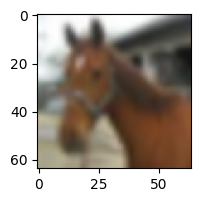

In [4]:
sample_data = next(iter(test_loader))

# Visualize the original image that is sample to test canonicalization
sample_image = invert_normalize(sample_data[0][0]).permute(1, 2, 0).numpy()

plt.figure(figsize=(2, 2))
plt.imshow(sample_image)
plt.show()

### 2. Check for canonicalization for steerable image canonicalizers



We first test it for SO(2) which is a 2D rotation group.
For this we first transform the image to k random rotations and then apply the steerable canonicalization to the image. 
We then check if the canonicalized image is the same as the original image.

In [5]:
# Transform the image using k random rotations
# number of random rotations
k = 4
# Original tensor image from the DataLoader
sample_image_tensor = sample_data[0][0]  # Assuming the first item is your image tensor

# Define an empty list to store the transformed tensor images
transformed_sample_images = []

# Get the shape of the image tensor
h, w = sample_image_tensor.shape[-2:]

# Pad the image to get rid of the black borders
pad = transforms.Pad(10, padding_mode='edge')

# crop the image to get rid of the black borders
crop = transforms.CenterCrop((h, w))
# Loop over the number of random rotations
# and transform the image tensor using torch rotation
for i in range(k):
    # Generate a random angle for rotation
    # angle = torch.rand(1).item() * 360  # Random rotation between 0 and 360 degrees
    angle = 90 * i
    
    # Pad the image to get rid of the black borders
    padded_image_tensor = pad(sample_image_tensor)
    
    # Apply the rotation to the tensor
    transformed_image_tensor = F.rotate(padded_image_tensor, angle)
    
    # Add the transformed tensor to the list
    transformed_sample_images.append(crop(transformed_image_tensor))



Function to visualize a list of image tensors.

In [6]:
# Function to plot image tensors in a square grid
def plot_image_tensors(image_tensors, titles=None, figsize=(4, 4)):
    """
    Plots a list of image tensors in a grid.

    Parameters:
    - image_tensors: List[Tensor]. A list of image tensors in (C, H, W) format.
    - titles: List[str]. Optional. A list of titles for each subplot.
    - figsize: tuple. The figure size.
    """
    # Determine the number of images
    num_images = len(image_tensors)

    # Calculate grid size for the subplots
    rows = int(torch.sqrt(torch.tensor(num_images)).item())
    cols = (num_images + rows - 1) // rows  # Ensure enough columns to display all images

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Flatten axes array for easy iteration, in case of a single row/column
    axes = axes.flatten()

    # Loop through all the images and their corresponding axes
    for i, (img_tensor, ax) in enumerate(zip(image_tensors, axes)):
        # Convert the tensor for visualization
        img_np = invert_normalize(img_tensor.squeeze()).permute(1, 2, 0).numpy()
        
        # Plot the image
        ax.imshow(img_np)
        ax.axis('off')  # Hide the axis

        # Set title if titles are provided
        if titles and i < len(titles):
            ax.set_title(titles[i])

    # If there are more axes than images, hide the extra axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

Visualize the transformed images

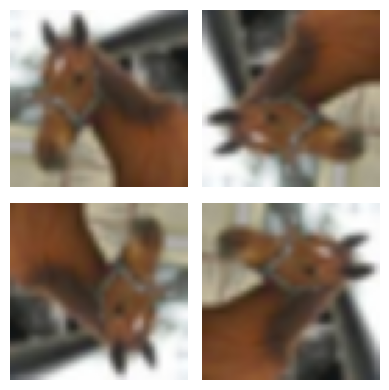

In [7]:
# Visualizing all the transformed images 
plot_image_tensors(transformed_sample_images)

Function to plot canonicalized images

In [8]:
def get_and_plot_canonicalized_images(transformed_sample_images, canonicalizer): 
    # Set the canonicalizer to evaluation mode
    canonicalizer.eval()
    
    # Get canonicalized images for all transformed images
    with torch.no_grad():
        canonicalized_images = []
        for im in transformed_sample_images:
            im = im.unsqueeze(0).to(device)
            canonicalized_image = canonicalizer.canonicalize(im)
            canonicalized_images.append(canonicalized_image.detach().cpu())

    # Visualizing all the canonicalized images
    plot_image_tensors(canonicalized_images)

Define a steerable canonicalization network and a SteerableImageCanonicalization object.

In [9]:
# Define the hyperparameters for the canonicalization network
class CanonicalizationHyperparams:
    def __init__(self):
        self.group_type = 'rotation'
        self.input_crop_ratio = 0.9
        self.resize_shape = 64 # The shape of the image after resizing

# Create an instance of the hyperparameters
canonicalization_hyperparams = CanonicalizationHyperparams()

# Get the shape of the image
image_shape = sample_image_tensor.squeeze().shape

# Print the image shape
print(f"Image shape: {image_shape}")

# Define a steerable canonicalization network
# Note that you define any steerable network here as long as it outputs 
# a vector that steers with the input image
# This vector is used to get a rotation matrix in a differentiable manner 
canonicalization_network = ESCNNSteerableNetwork(
    in_shape = image_shape,
    out_channels=16, 
    kernel_size= 7, 
    num_layers = 3
).to(device)


# Create a steerable canonicalization object
canonicalizer = SteerableImageCanonicalization(
    canonicalization_network=canonicalization_network,
    canonicalization_hyperparams=canonicalization_hyperparams,
    in_shape=image_shape,
)

Image shape: torch.Size([3, 64, 64])


Canonicalize all the transformed images and visualize the canonicalized images.

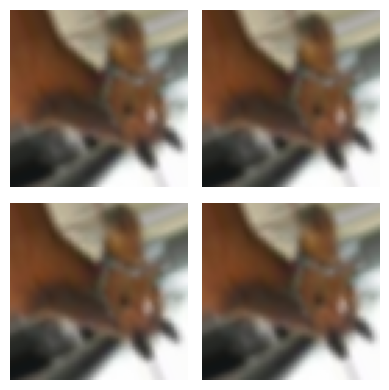

In [10]:
# Get canonicalized images for all transformed images
get_and_plot_canonicalized_images(transformed_sample_images, canonicalizer)

In [13]:
# Train the canonicalization network using prior regularization

# Define the optimizer
optimizer = torch.optim.Adam(canonicalization_network.parameters(), lr=0.0005)

# Set the canonicalizer to training mode
canonicalizer.train()

# Set a weight for the prior regularization loss
prior_regularization_weight = 100

# Define the training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Initialize tqdm with an initial description
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    identity_metric = 0
    total_loss = 0  # To track the total loss for averaging
    
    for image, _ in train_loader_tqdm:
        # Zero the gradients
        optimizer.zero_grad()
        
        image = image.to(device)
        canonicalized_image = canonicalizer.canonicalize(image)
        
        # Get the prior regularization loss
        loss = prior_regularization_weight * canonicalizer.get_prior_regularization_loss()
        
        # Backpropagate the gradients
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Update the running average of identity metric
        identity_metric += canonicalizer.get_identity_metric()

        # Update total loss for averaging
        total_loss += loss.item()

        # Update tqdm description with current loss (average loss per batch)
        train_loader_tqdm.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/(train_loader_tqdm.n + 1):.4f}")
    
    # Calculate and print the average loss and identity metric over the epoch
    avg_loss = total_loss / len(train_loader)
    identity_metric /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}, Identity Metric: {identity_metric:.4f}")   

Epoch 1/100, Loss: 74.5067: 100%|██████████| 98/98 [00:54<00:00,  1.79it/s]


Epoch 1/100, Average Loss: 74.5067, Identity Metric: 0.2549


Epoch 2/100, Loss: 69.7839: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 2/100, Average Loss: 69.7839, Identity Metric: 0.3022


Epoch 3/100, Loss: 65.0352: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 3/100, Average Loss: 65.0352, Identity Metric: 0.3496


Epoch 4/100, Loss: 63.1781: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 4/100, Average Loss: 63.1781, Identity Metric: 0.3682


Epoch 5/100, Loss: 62.8555: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 5/100, Average Loss: 62.8555, Identity Metric: 0.3714


Epoch 6/100, Loss: 60.8193: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 6/100, Average Loss: 60.8193, Identity Metric: 0.3918


Epoch 7/100, Loss: 59.7673: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 7/100, Average Loss: 59.7673, Identity Metric: 0.4023


Epoch 8/100, Loss: 59.0418: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 8/100, Average Loss: 59.0418, Identity Metric: 0.4096


Epoch 9/100, Loss: 58.4901: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 9/100, Average Loss: 58.4901, Identity Metric: 0.4151


Epoch 10/100, Loss: 57.5616: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 10/100, Average Loss: 57.5616, Identity Metric: 0.4244


Epoch 11/100, Loss: 58.1359: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 11/100, Average Loss: 58.1359, Identity Metric: 0.4186


Epoch 12/100, Loss: 57.8884: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 12/100, Average Loss: 57.8884, Identity Metric: 0.4211


Epoch 13/100, Loss: 56.9046: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 13/100, Average Loss: 56.9046, Identity Metric: 0.4310


Epoch 14/100, Loss: 56.4850: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 14/100, Average Loss: 56.4850, Identity Metric: 0.4352


Epoch 15/100, Loss: 55.9049: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 15/100, Average Loss: 55.9049, Identity Metric: 0.4410


Epoch 16/100, Loss: 57.4024: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 16/100, Average Loss: 57.4024, Identity Metric: 0.4260


Epoch 17/100, Loss: 61.3788: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 17/100, Average Loss: 61.3788, Identity Metric: 0.3862


Epoch 18/100, Loss: 56.4731: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 18/100, Average Loss: 56.4731, Identity Metric: 0.4353


Epoch 19/100, Loss: 55.7751: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 19/100, Average Loss: 55.7751, Identity Metric: 0.4422


Epoch 20/100, Loss: 55.6377: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 20/100, Average Loss: 55.6377, Identity Metric: 0.4436


Epoch 21/100, Loss: 55.2273: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 21/100, Average Loss: 55.2273, Identity Metric: 0.4477


Epoch 22/100, Loss: 54.6625: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 22/100, Average Loss: 54.6625, Identity Metric: 0.4534


Epoch 23/100, Loss: 54.2824: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 23/100, Average Loss: 54.2824, Identity Metric: 0.4572


Epoch 24/100, Loss: 56.7606: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 24/100, Average Loss: 56.7606, Identity Metric: 0.4324


Epoch 25/100, Loss: 56.2325: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 25/100, Average Loss: 56.2325, Identity Metric: 0.4377


Epoch 26/100, Loss: 73.3314: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 26/100, Average Loss: 73.3314, Identity Metric: 0.2667


Epoch 27/100, Loss: 66.8055: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 27/100, Average Loss: 66.8055, Identity Metric: 0.3319


Epoch 28/100, Loss: 61.1384: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 28/100, Average Loss: 61.1384, Identity Metric: 0.3886


Epoch 29/100, Loss: 58.0874: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 29/100, Average Loss: 58.0874, Identity Metric: 0.4191


Epoch 30/100, Loss: 57.1930: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 30/100, Average Loss: 57.1930, Identity Metric: 0.4281


Epoch 31/100, Loss: 55.1297: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 31/100, Average Loss: 55.1297, Identity Metric: 0.4487


Epoch 32/100, Loss: 55.1177: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 32/100, Average Loss: 55.1177, Identity Metric: 0.4488


Epoch 33/100, Loss: 54.5812: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 33/100, Average Loss: 54.5812, Identity Metric: 0.4542


Epoch 34/100, Loss: 54.3781: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 34/100, Average Loss: 54.3781, Identity Metric: 0.4562


Epoch 35/100, Loss: 54.0581: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 35/100, Average Loss: 54.0581, Identity Metric: 0.4594


Epoch 36/100, Loss: 53.4974: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 36/100, Average Loss: 53.4974, Identity Metric: 0.4650


Epoch 37/100, Loss: 54.0578: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 37/100, Average Loss: 54.0578, Identity Metric: 0.4594


Epoch 38/100, Loss: 53.8551: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 38/100, Average Loss: 53.8551, Identity Metric: 0.4614


Epoch 39/100, Loss: 53.0427: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 39/100, Average Loss: 53.0427, Identity Metric: 0.4696


Epoch 40/100, Loss: 53.2044: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 40/100, Average Loss: 53.2044, Identity Metric: 0.4680


Epoch 41/100, Loss: 53.1333: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 41/100, Average Loss: 53.1333, Identity Metric: 0.4687


Epoch 42/100, Loss: 52.4842: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 42/100, Average Loss: 52.4842, Identity Metric: 0.4752


Epoch 43/100, Loss: 52.5879: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 43/100, Average Loss: 52.5879, Identity Metric: 0.4741


Epoch 44/100, Loss: 52.4725: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 44/100, Average Loss: 52.4725, Identity Metric: 0.4753


Epoch 45/100, Loss: 56.1107: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 45/100, Average Loss: 56.1107, Identity Metric: 0.4389


Epoch 46/100, Loss: 52.7328: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 46/100, Average Loss: 52.7328, Identity Metric: 0.4727


Epoch 47/100, Loss: 52.7295: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 47/100, Average Loss: 52.7295, Identity Metric: 0.4727


Epoch 48/100, Loss: 52.6841: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 48/100, Average Loss: 52.6841, Identity Metric: 0.4732


Epoch 49/100, Loss: 52.0909: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 49/100, Average Loss: 52.0909, Identity Metric: 0.4791


Epoch 50/100, Loss: 53.3640: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 50/100, Average Loss: 53.3640, Identity Metric: 0.4664


Epoch 51/100, Loss: 51.8860: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 51/100, Average Loss: 51.8860, Identity Metric: 0.4811


Epoch 52/100, Loss: 52.8442: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 52/100, Average Loss: 52.8442, Identity Metric: 0.4716


Epoch 53/100, Loss: 52.4524: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 53/100, Average Loss: 52.4524, Identity Metric: 0.4755


Epoch 54/100, Loss: 52.6208: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 54/100, Average Loss: 52.6208, Identity Metric: 0.4738


Epoch 55/100, Loss: 66.0447: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 55/100, Average Loss: 66.0447, Identity Metric: 0.3396


Epoch 56/100, Loss: 54.4663: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 56/100, Average Loss: 54.4663, Identity Metric: 0.4553


Epoch 57/100, Loss: 52.4705: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 57/100, Average Loss: 52.4705, Identity Metric: 0.4753


Epoch 58/100, Loss: 51.4522: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 58/100, Average Loss: 51.4522, Identity Metric: 0.4855


Epoch 59/100, Loss: 51.0452: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 59/100, Average Loss: 51.0452, Identity Metric: 0.4895


Epoch 60/100, Loss: 51.2621: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 60/100, Average Loss: 51.2621, Identity Metric: 0.4874


Epoch 61/100, Loss: 50.8961: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 61/100, Average Loss: 50.8961, Identity Metric: 0.4910


Epoch 62/100, Loss: 50.8872: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 62/100, Average Loss: 50.8872, Identity Metric: 0.4911


Epoch 63/100, Loss: 50.4284: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 63/100, Average Loss: 50.4284, Identity Metric: 0.4957


Epoch 64/100, Loss: 66.7320: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 64/100, Average Loss: 66.7320, Identity Metric: 0.3327


Epoch 65/100, Loss: 59.3587: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 65/100, Average Loss: 59.3587, Identity Metric: 0.4064


Epoch 66/100, Loss: 53.7840: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 66/100, Average Loss: 53.7840, Identity Metric: 0.4622


Epoch 67/100, Loss: 51.3837: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 67/100, Average Loss: 51.3837, Identity Metric: 0.4862


Epoch 68/100, Loss: 51.9580: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 68/100, Average Loss: 51.9580, Identity Metric: 0.4804


Epoch 69/100, Loss: 50.8486: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 69/100, Average Loss: 50.8486, Identity Metric: 0.4915


Epoch 70/100, Loss: 50.5525: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 70/100, Average Loss: 50.5525, Identity Metric: 0.4945


Epoch 71/100, Loss: 51.3024: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 71/100, Average Loss: 51.3024, Identity Metric: 0.4870


Epoch 72/100, Loss: 50.8956: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 72/100, Average Loss: 50.8956, Identity Metric: 0.4910


Epoch 73/100, Loss: 52.2140: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]


Epoch 73/100, Average Loss: 52.2140, Identity Metric: 0.4779


Epoch 74/100, Loss: 50.1522: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 74/100, Average Loss: 50.1522, Identity Metric: 0.4985


Epoch 75/100, Loss: 55.4401: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 75/100, Average Loss: 55.4401, Identity Metric: 0.4456


Epoch 76/100, Loss: 57.3310: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 76/100, Average Loss: 57.3310, Identity Metric: 0.4267


Epoch 77/100, Loss: 51.0955: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 77/100, Average Loss: 51.0955, Identity Metric: 0.4890


Epoch 78/100, Loss: 53.2048: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 78/100, Average Loss: 53.2048, Identity Metric: 0.4680


Epoch 79/100, Loss: 50.9074: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 79/100, Average Loss: 50.9074, Identity Metric: 0.4909


Epoch 80/100, Loss: 50.2306: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 80/100, Average Loss: 50.2306, Identity Metric: 0.4977


Epoch 81/100, Loss: 51.1902: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]


Epoch 81/100, Average Loss: 51.1902, Identity Metric: 0.4881


Epoch 82/100, Loss: 52.0834:  78%|███████▊  | 76/98 [00:42<00:12,  1.80it/s]


KeyboardInterrupt: 

Canonicalize all the transformed images and visualize them after prior regularization.

The canonicalization network is able to generate the canonical orientation which are in the training data distribution.

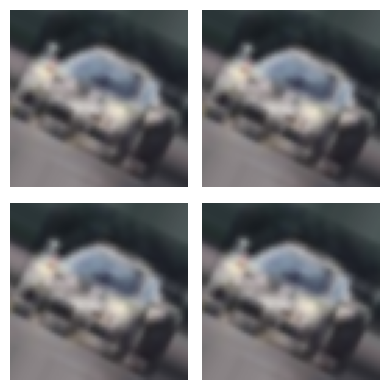

In [14]:
# Visualize the canonicalized images after training the canonicalization network using prior regularization
get_and_plot_canonicalized_images(transformed_sample_images, canonicalizer)

### 2. Check canonicalization using the optimization based method for continuous groups

In [23]:
# Define the hyperparameters for the canonicalization network
class CanonicalizationHyperparams:
    def __init__(self):
        self.group_type = "rotation" # Type of group for the canonization network
        self.input_crop_ratio = 0.9 # The ratio of the input image to crop
        self.resize_shape = 64 # The shape of the image after resizing

# Create an instance of the hyperparameters
canonicalization_hyperparams = CanonicalizationHyperparams()

# Get the shape of the image
image_shape = sample_image_tensor.squeeze().shape

# Print the image shape
print(f"Image shape: {image_shape}")

# Define a steerable canonicalization network
# Note that you define any steerable network here as long as it outputs 
# a vector that steers with the input image
# This vector is used to get a rotation matrix in a differentiable manner 
canonicalization_network = ConvNetwork(
    in_shape = image_shape,
    out_channels=16, 
    kernel_size= 5, 
    num_layers = 3,
    out_vector_size=4,
).to(device)


# Create a steerable canonicalization object
canonicalizer = OptimizedSteerableImageCanonicalization(
    canonicalization_network=canonicalization_network,
    canonicalization_hyperparams=canonicalization_hyperparams,
    in_shape=image_shape,
).to(device)

Image shape: torch.Size([3, 64, 64])


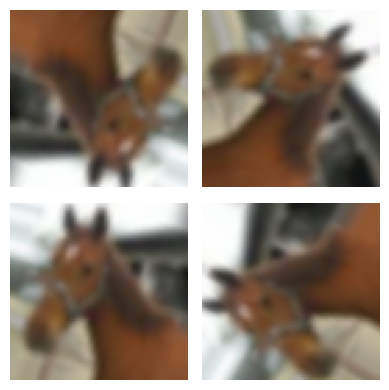

In [25]:
# Visualize the canonicalized images before training the canonicalization network using optimization method
get_and_plot_canonicalized_images(transformed_sample_images, canonicalizer)

In [13]:
x_augmented, group_element_representations_augmented_gt = canonicalizer.group_augment(transformed_sample_images[0].unsqueeze(0).to(device))

In [14]:
x_augmented.shape

torch.Size([1, 3, 64, 64])

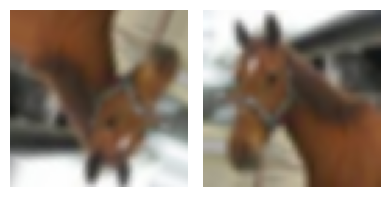

In [15]:
plot_image_tensors([x_augmented.detach().cpu(), transformed_sample_images[0]])

In [16]:
group_element_representations_augmented_gt

tensor([[[-0.9353,  0.3539],
         [-0.3539, -0.9353]]], device='cuda:0')

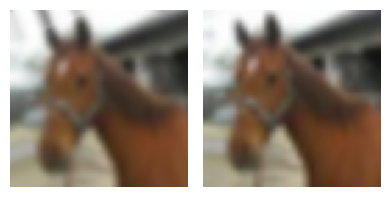

In [17]:
rotation_matrices = group_element_representations_augmented_gt

assert rotation_matrices.shape == (1, 2, 2)
# To apply inverse rotation for canonicalization
rotation_matrices[:, [0, 1], [1, 0]] *= -1

x = x_augmented

# Apply padding before canonicalization
x = pad(x)

# Compute affine part for warp affine
alpha, beta = rotation_matrices[:, 0, 0], rotation_matrices[:, 0, 1]
cx, cy = x.shape[-2] // 2, x.shape[-1] // 2
affine_part = torch.stack([(1 - alpha) * cx - beta * cy, beta * cx + (1 - alpha) * cy], dim=1)

# Prepare affine matrices for warp affine, adjusting rotation matrix for Kornia compatibility
affine_matrices = torch.cat([rotation_matrices, affine_part.unsqueeze(-1)], dim=-1)

# Apply warp affine, and then crop     
x = K.geometry.warp_affine(x, affine_matrices, dsize=(x.shape[-2], x.shape[-1]))
x = crop(x)
plot_image_tensors([x.detach().cpu(), transformed_sample_images[0]])


In [24]:
# Train the canonicalization network using prior regularization and optimization specific loss

# Define the optimizer
optimizer = torch.optim.Adam(canonicalization_network.parameters(), lr=0.0002)

# Set the canonicalizer to training mode
canonicalizer.train()

# Set weights for the losses
prior_regularization_weight = 0
optimization_specific_loss_weight = 100

# Define the training loop
num_epochs = 50
for epoch in range(num_epochs):
    # Initialize tqdm with an initial description
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    identity_metric = 0
    total_prior_loss = 0  # To track the total prior regularization loss for averaging
    total_optimization_specific_loss = 0  # To track the total optimization specific loss for averaging
    
    for image, _ in train_loader_tqdm:
        # Zero the gradients
        optimizer.zero_grad()
        
        image = image.to(device)
        canonicalized_image = canonicalizer.canonicalize(image)
        
        # Get the prior regularization loss
        prior_loss = canonicalizer.get_prior_regularization_loss()
        
        # Get the optimization specific loss
        optimization_specific_loss = canonicalizer.get_optimization_specific_loss()
        
        # Combine the losses
        loss = prior_regularization_weight * prior_loss + optimization_specific_loss_weight * optimization_specific_loss
        
        # Backpropagate the gradients
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        # Update the running average of identity metric and loss totals
        identity_metric += canonicalizer.get_identity_metric()
        total_prior_loss += prior_loss.item()
        total_optimization_specific_loss += optimization_specific_loss.item()

        # Update tqdm description with current losses
        train_loader_tqdm.set_description(f"Epoch {epoch+1}/{num_epochs}, \
                                          Prior Loss: {total_prior_loss/(train_loader_tqdm.n + 1):.4f}, \
                                          Opt Loss: {total_optimization_specific_loss/(train_loader_tqdm.n + 1):.4f}")
    
    # Calculate and print the average losses and identity metric over the epoch
    avg_prior_loss = total_prior_loss / len(train_loader)
    avg_optimization_specific_loss = total_optimization_specific_loss / len(train_loader)
    identity_metric /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Prior Loss: {avg_prior_loss:.4f}, \
          Avg Opt Loss: {avg_optimization_specific_loss:.4f}, Identity Metric: {identity_metric:.4f}")

   

Epoch 1/50,                                           Prior Loss: 0.8520,                                           Opt Loss: 0.9662: 100%|██████████| 98/98 [00:21<00:00,  4.48it/s]


Epoch 1/50, Avg Prior Loss: 0.8520,           Avg Opt Loss: 0.9662, Identity Metric: 0.1480


Epoch 2/50,                                           Prior Loss: 0.8010,                                           Opt Loss: 0.9526: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]


Epoch 2/50, Avg Prior Loss: 0.8010,           Avg Opt Loss: 0.9526, Identity Metric: 0.1990


Epoch 3/50,                                           Prior Loss: 0.8151,                                           Opt Loss: 0.9527: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]


Epoch 3/50, Avg Prior Loss: 0.8151,           Avg Opt Loss: 0.9527, Identity Metric: 0.1849


Epoch 4/50,                                           Prior Loss: 0.7514,                                           Opt Loss: 0.9502: 100%|██████████| 98/98 [00:22<00:00,  4.43it/s]


Epoch 4/50, Avg Prior Loss: 0.7514,           Avg Opt Loss: 0.9502, Identity Metric: 0.2486


Epoch 5/50,                                           Prior Loss: 0.8589,                                           Opt Loss: 0.9491: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]


Epoch 5/50, Avg Prior Loss: 0.8589,           Avg Opt Loss: 0.9491, Identity Metric: 0.1411


Epoch 6/50,                                           Prior Loss: 0.7934,                                           Opt Loss: 0.9478: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]


Epoch 6/50, Avg Prior Loss: 0.7934,           Avg Opt Loss: 0.9478, Identity Metric: 0.2066


Epoch 7/50,                                           Prior Loss: 0.8147,                                           Opt Loss: 0.9445: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]


Epoch 7/50, Avg Prior Loss: 0.8147,           Avg Opt Loss: 0.9445, Identity Metric: 0.1853


Epoch 8/50,                                           Prior Loss: 0.8863,                                           Opt Loss: 0.9458: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]


Epoch 8/50, Avg Prior Loss: 0.8863,           Avg Opt Loss: 0.9458, Identity Metric: 0.1137


Epoch 9/50,                                           Prior Loss: 0.8430,                                           Opt Loss: 0.9390: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]


Epoch 9/50, Avg Prior Loss: 0.8430,           Avg Opt Loss: 0.9390, Identity Metric: 0.1570


Epoch 10/50,                                           Prior Loss: 0.8238,                                           Opt Loss: 0.9407: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]


Epoch 10/50, Avg Prior Loss: 0.8238,           Avg Opt Loss: 0.9407, Identity Metric: 0.1762


Epoch 11/50,                                           Prior Loss: 0.8368,                                           Opt Loss: 0.9424: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]


Epoch 11/50, Avg Prior Loss: 0.8368,           Avg Opt Loss: 0.9424, Identity Metric: 0.1632


Epoch 12/50,                                           Prior Loss: 0.8361,                                           Opt Loss: 0.9454: 100%|██████████| 98/98 [00:21<00:00,  4.48it/s]


Epoch 12/50, Avg Prior Loss: 0.8361,           Avg Opt Loss: 0.9454, Identity Metric: 0.1639


Epoch 13/50,                                           Prior Loss: 0.7876,                                           Opt Loss: 0.9390: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]


Epoch 13/50, Avg Prior Loss: 0.7876,           Avg Opt Loss: 0.9390, Identity Metric: 0.2124


Epoch 14/50,                                           Prior Loss: 0.8465,                                           Opt Loss: 0.9381: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]


Epoch 14/50, Avg Prior Loss: 0.8465,           Avg Opt Loss: 0.9381, Identity Metric: 0.1535


Epoch 15/50,                                           Prior Loss: 0.8116,                                           Opt Loss: 0.9354: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]


Epoch 15/50, Avg Prior Loss: 0.8116,           Avg Opt Loss: 0.9354, Identity Metric: 0.1884


Epoch 16/50,                                           Prior Loss: 0.9120,                                           Opt Loss: 0.9433: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]


Epoch 16/50, Avg Prior Loss: 0.9120,           Avg Opt Loss: 0.9433, Identity Metric: 0.0880


Epoch 17/50,                                           Prior Loss: 0.9157,                                           Opt Loss: 0.9417:  31%|███       | 30/98 [00:06<00:15,  4.36it/s]


KeyboardInterrupt: 